In [2]:
import os
import time
import uuid
import cv2

import albumentations as alb
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model

In [5]:
# Limit GPU Memory Growth
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

# Reference

- https://github.com/wkentaro/labelme
- https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
- https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch
- https://www.youtube.com/watch?v=N_W4EYtsa10

# Consts and Vars

In [7]:
IMAGE_SIZE = (120, 120)
IMAGE_SHAPE = IMAGE_SIZE + (3,)
WEBCAM_SIZE = (640, 480)

CLASSES = ['face']
NUM_CLASSES = len(CLASSES)
NUM_PARAMS_BBOX = 4

TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15

AUG_IMG_SIZE = [450, 450]
NUM_AUGMENTED_IMGS = 60

BATCH_SIZE = 8
PREFETCH_SIZE = 4 # Eliminate bottle neck

# DATA

## Collection

In [ ]:
# Install Dependencies and Setup
# !pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

In [3]:
DATA_PATH = os.path.join('data')
IMAGES_PATH = os.path.join(DATA_PATH,'images')
LABELS_PATH = os.path.join(DATA_PATH,'labels')

In [ ]:
# Create folder for images and labels
os.makedirs(IMAGES_PATH, exist_ok=True)
os.makedirs(LABELS_PATH, exist_ok=True)

In [12]:
NUMBER_IMAGES = 30

cap = cv2.VideoCapture(0)
for imgnum in range(NUMBER_IMAGES):
    ret, frame = cap.read()
    frame = cv2.flip(frame, 1)
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.putText(frame, f'{imgnum + 1}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 
                0.6, (0, 255, 0), 2)
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()

In [4]:
# Annotate Images with LabelMe
# !labelme

## Review

In [6]:
# Load Image into TF Data Pipeline 
def load_image(file_path): 
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [30]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')
# print(images.as_numpy_iterator().next())

# Apply the function to each element in the dataset using the map method
images = images.map(load_image)
# print(images.as_numpy_iterator().next())
# print(type(image))

In [ ]:
# View Raw Images with Matplotlib
image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

## Partition

In [11]:
# MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

DATA_PATH = os.path.join('data')
TRAIN_PATH = os.path.join(DATA_PATH,'train')
VAL_PATH = os.path.join(DATA_PATH,'val')
TEST_PATH = os.path.join(DATA_PATH,'test')

TRAIN_IMAGES_PATH = os.path.join(TRAIN_PATH,'images')
VAL_IMAGES_PATH = os.path.join(VAL_PATH,'images')
TEST_IMAGES_PATH = os.path.join(TEST_PATH,'images')
TRAIN_LABELS_PATH = os.path.join(TRAIN_PATH, 'labels')
VAL_LABELS_PATH = os.path.join(VAL_PATH, 'labels')
TEST_LABELS_PATH = os.path.join(TEST_PATH, 'labels')

In [ ]:
# Create folder for train, val, test
os.makedirs(TRAIN_PATH, exist_ok=True)
os.makedirs(VAL_PATH, exist_ok=True)
os.makedirs(TEST_PATH, exist_ok=True)

# Create folder for images and labels
os.makedirs(TRAIN_IMAGES_PATH, exist_ok=True)
os.makedirs(VAL_IMAGES_PATH, exist_ok=True)
os.makedirs(TEST_IMAGES_PATH, exist_ok=True)
os.makedirs(TRAIN_LABELS_PATH, exist_ok=True)
os.makedirs(VAL_LABELS_PATH, exist_ok=True)
os.makedirs(TEST_LABELS_PATH, exist_ok=True)

image_paths = os.listdir(os.path.join(DATA_PATH,'images'))
# Move files in images folder to train, val, test folder accorrding to the split
for image_path in image_paths[:int(len(image_paths)*TRAIN_SPLIT)]:
    os.rename(os.path.join(DATA_PATH,'images',image_path),
              os.path.join(TRAIN_IMAGES_PATH,image_path))
# Val
for image_path in image_paths[int(len(image_paths)*TRAIN_SPLIT):int(len(image_paths)*(TRAIN_SPLIT+VAL_SPLIT))]:
    os.rename(os.path.join(DATA_PATH,'images',image_path),
              os.path.join(VAL_IMAGES_PATH,image_path))
# Test
for image_path in image_paths[int(len(image_paths)*(TRAIN_SPLIT+VAL_SPLIT)):]:
    os.rename(os.path.join(DATA_PATH,'images',image_path),
              os.path.join(TEST_IMAGES_PATH,image_path))
    
label_paths = os.listdir(os.path.join(DATA_PATH,'labels'))
# Move file in labels folder to train, val, test folder accorrding to the split
# Train
for label in label_paths[:int(len(label_paths)*TRAIN_SPLIT)]:
    os.rename(os.path.join(DATA_PATH,'labels',label),
              os.path.join(TRAIN_LABELS_PATH,label))
# Val
for label in label_paths[int(len(label_paths)*TRAIN_SPLIT):int(len(label_paths)*(TRAIN_SPLIT+VAL_SPLIT))]:
    os.rename(os.path.join(DATA_PATH,'labels',label),
              os.path.join(VAL_LABELS_PATH,label))
# Test
for label in label_paths[int(len(label_paths)*(TRAIN_SPLIT+VAL_SPLIT)):]:
    os.rename(os.path.join(DATA_PATH,'labels',label),
              os.path.join(TEST_LABELS_PATH,label))

## Image Augmentation on Images and Labels using Albumentations
![image](bounding_box_coordinates.jpg)

In [12]:
# Setup Albumentations Transform Pipeline
augmentor = alb.Compose([alb.RandomCrop(width=AUG_IMG_SIZE[0], 
                                        height=AUG_IMG_SIZE[0]), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [17]:
# Load a Test Image and Annotation with OpenCV and JSON
# pascal_volc
# [x_min, y_min, x_max, y_max]

img = cv2.imread(os.path.join(TRAIN_IMAGES_PATH, os.listdir(TRAIN_IMAGES_PATH)[0]))
with open(os.path.join(TRAIN_LABELS_PATH, os.listdir(TRAIN_LABELS_PATH)[0]), 'r') as f:
    label = json.load(f)

print(label['shapes'][0], '\n');

# Extract Coordinates and Rescale to Match Image Resolution
label_points = label['shapes'][0]['points']
coords = [0,0,0,0]
coords[0] = label_points[0][0]
coords[1] = label_points[0][1]
coords[2] = label_points[1][0]
coords[3] = label_points[1][1]
print(f'coords:{coords}', '\n');

coords = list(np.divide(coords, [WEBCAM_SIZE[0], WEBCAM_SIZE[1], WEBCAM_SIZE[0], WEBCAM_SIZE[1]]))
print(f'coords:{coords}', '\n');

{'label': 'face', 'points': [[141.60804020100502, 268.84422110552765], [318.4924623115578, 423.6180904522613]], 'group_id': None, 'shape_type': 'rectangle', 'flags': {}} 

coords:
[141.60804020100502, 268.84422110552765, 318.4924623115578, 423.6180904522613] 

coords:
[0.22126256281407036, 0.5600921273031826, 0.4976444723618091, 0.882537688442211] 



<class 'dict'>
dict_keys(['image', 'bboxes', 'class_labels'])
(450, 450, 3)
['face']
[(0.1991289782244556, 0.06084868788386377, 0.5922054718034618, 0.40479061976549413)]


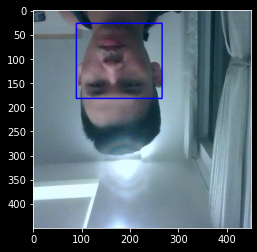

In [21]:
# Apply Augmentations and View Results
augmented = augmentor(image=img, bboxes=[coords], class_labels=CLASSES)

print(type(augmented), augmented.keys(), augmented['image'].shape,
      augmented['class_labels'], augmented['bboxes'], sep='\n')

cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], AUG_IMG_SIZE).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], AUG_IMG_SIZE).astype(int)), 
              (255,0,0), 2)
plt.imshow(cv2.cvtColor(augmented['image'], cv2.COLOR_BGR2RGB))
plt.show()

In [13]:
# Build and Run Augmentation Pipeline
# Create aug_data folder
AUG_DATA_PATH = os.path.join('aug_data')

AUG_DATA_TRAIN_PATH = os.path.join(AUG_DATA_PATH, 'train')
AUG_DATA_VAL_PATH = os.path.join(AUG_DATA_PATH, 'val')
AUG_DATA_TEST_PATH = os.path.join(AUG_DATA_PATH, 'test')

AUG_DATA_TRAIN_IMAGES_PATH = os.path.join(AUG_DATA_TRAIN_PATH, 'images')
AUG_DATA_TRAIN_LABELS_PATH = os.path.join(AUG_DATA_TRAIN_PATH, 'labels')
AUG_DATA_VAL_IMAGES_PATH = os.path.join(AUG_DATA_VAL_PATH, 'images')
AUG_DATA_VAL_LABELS_PATH = os.path.join(AUG_DATA_VAL_PATH, 'labels')
AUG_DATA_TEST_IMAGES_PATH = os.path.join(AUG_DATA_TEST_PATH, 'images')
AUG_DATA_TEST_LABELS_PATH = os.path.join(AUG_DATA_TEST_PATH, 'labels')


In [ ]:
os.makedirs(AUG_DATA_PATH, exist_ok=True)
os.makedirs(AUG_DATA_TRAIN_PATH, exist_ok=True)
os.makedirs(AUG_DATA_VAL_PATH, exist_ok=True)
os.makedirs(AUG_DATA_TEST_PATH, exist_ok=True)
os.makedirs(AUG_DATA_TRAIN_IMAGES_PATH, exist_ok=True)
os.makedirs(AUG_DATA_TRAIN_LABELS_PATH, exist_ok=True)
os.makedirs(AUG_DATA_VAL_IMAGES_PATH, exist_ok=True)
os.makedirs(AUG_DATA_VAL_LABELS_PATH, exist_ok=True)
os.makedirs(AUG_DATA_TEST_IMAGES_PATH, exist_ok=True)
os.makedirs(AUG_DATA_TEST_LABELS_PATH, exist_ok=True)

In [27]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        # Default annotation for img doesn't have annotation
        coords = [0,0,0.00001,0.00001] 
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path): # Is this image has label
            with open(label_path, 'r') as f:
                label = json.load(f)

            label_points = label['shapes'][0]['points']
            coords = [0,0,0,0]
            coords[0] = label_points[0][0]
            coords[1] = label_points[0][1]
            coords[2] = label_points[1][0]
            coords[3] = label_points[1][1]
            coords = list(np.divide(coords, [WEBCAM_SIZE[0], WEBCAM_SIZE[1], 
                                             WEBCAM_SIZE[0], WEBCAM_SIZE[1]]))

        try: 
            # Create NUM_AUGMENTED_IMGS imgs per base img
            for x in range(NUM_AUGMENTED_IMGS):
                # Run the img through the augmentation pipeline
                augmented = augmentor(image=img, bboxes=[coords], 
                                      class_labels=CLASSES)
                cv2.imwrite(os.path.join(AUG_DATA_PATH, partition, 'images', 
                        f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 

                with open(os.path.join(AUG_DATA_PATH, partition, 'labels', 
                                f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.6201319095477387, 0.4878559463986599, 0.2620917085427136, 0.9118509212730319, 'face'].
x_max is less than or equal to x_min for bbox [0.5785175879396985, 0.46273031825795646, 0.21498115577889448, 0.9244137353433836, 'face'].
x_max is less than or equal to x_min for bbox [0.5612437185929648, 0.4376046901172529, 0.1937814070351759, 0.8982412060301507, 'face'].
x_max is less than or equal to x_min for bbox [0.5651695979899498, 0.4585427135678392, 0.22283291457286433, 0.855318257956449, 'face'].
x_max is less than or equal to x_min for bbox [0.5957914572864322, 0.46587102177554435, 0.27543969849246236, 0.8563651591289783, 'face'].
x_max is less than or equal to x_min for bbox [0.6107097989949748, 0.46168341708542715, 0.2558103015075377, 0.8877721943048577, 'face'].
x_max is less than or equal to x_min for bbox [0.605998743718593, 0.4763400335008375, 0.22283291457286433, 0.9317420435510887, 'face'].
x_max is less than or equal to x_min for bb

## Tensorflow Dataset

In [14]:
# Load Augmented Images to Tensorflow Dataset
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, IMAGE_SIZE))
train_images = train_images.map(lambda x: x/255)

test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, IMAGE_SIZE))
test_images = test_images.map(lambda x: x/255)

val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, IMAGE_SIZE))
val_images = val_images.map(lambda x: x/255)

In [29]:
train_images.as_numpy_iterator().next()

array([[[0.11164216, 0.12977941, 0.14307599],
        [0.1533701 , 0.13664216, 0.1288603 ],
        [0.41672793, 0.35202205, 0.32126224],
        ...,
        [0.33547795, 0.33547795, 0.34332108],
        [0.33890933, 0.33498776, 0.35802695],
        [0.42487746, 0.4209559 , 0.44754902]],

       [[0.13351716, 0.13143383, 0.12879902],
        [0.17622548, 0.14681372, 0.1242647 ],
        [0.37769607, 0.3125    , 0.2737745 ],
        ...,
        [0.3283701 , 0.3283701 , 0.33621323],
        [0.37542892, 0.37150735, 0.39454657],
        [0.43284315, 0.42892158, 0.45343137]],

       [[0.14479166, 0.13272059, 0.14479166],
        [0.18970588, 0.14270833, 0.14172794],
        [0.35134804, 0.27732843, 0.26164216],
        ...,
        [0.33400735, 0.33400735, 0.3418505 ],
        [0.371875  , 0.36795342, 0.39099264],
        [0.43590686, 0.42984068, 0.46507353]],

       ...,

       [[0.6266544 , 0.64234066, 0.6462622 ],
        [0.65091914, 0.6666054 , 0.6783701 ],
        [0.6370711 , 0

## Labels

In [15]:
# Build Label Loading Function
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [16]:
# Load Labels to Tensorflow Dataset
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [32]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.     , 0.12085, 0.3745 , 0.4648 ], dtype=float16))

## Combine Label and Image Samples

In [33]:
# Partition Lengths
print(f'len(train_images): {len(train_images)}')
print(f'len(train_labels): {len(train_labels)}')
print(f'len(test_images): {len(test_images)}')
print(f'len(test_labels): {len(test_labels)}')
print(f'len(val_images): {len(val_images)}')
print(f'len(val_labels): {len(val_labels)}')

len(train_images): 3960
len(train_labels): 3960
len(test_images): 360
len(test_labels): 360
len(val_images): 660
len(val_labels): 660


In [17]:
# Create Final Datasets (Images/Labels)
# Shuffle size should be large than len(images/label)
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000).batch(BATCH_SIZE).prefetch(PREFETCH_SIZE)
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300).batch(BATCH_SIZE).prefetch(PREFETCH_SIZE)
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000).batch(BATCH_SIZE).prefetch(PREFETCH_SIZE)

In [45]:
next_batch = train.as_numpy_iterator().next()

print(f'Image shape: {next_batch[0].shape}')
print(f'Label shape: {len(next_batch[1])}')
print(f'Label Class shape: {next_batch[1][0].shape}')
print(f'Label Bounding Box shape: {next_batch[1][1].shape}')

Image shape: (8, 120, 120, 3)
Label shape: 2
Label Class shape: (8, 1)
Label Bounding Box shape: (8, 4)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


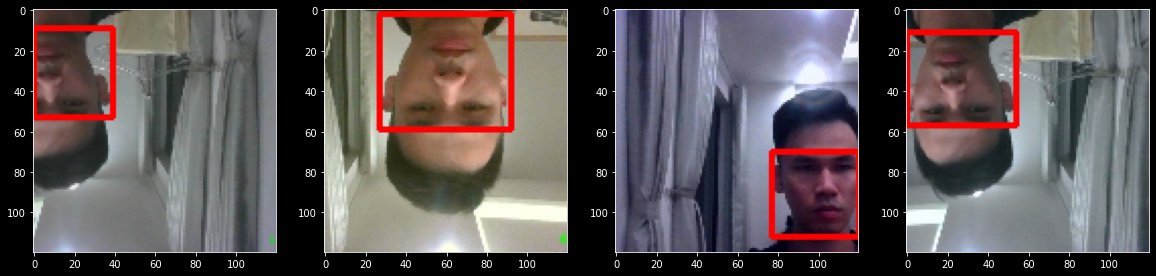

In [46]:
# View Images and Annotations
data_samples = train.as_numpy_iterator()
current_batch = data_samples.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = current_batch[0][idx]
    sample_coords = current_batch[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], IMAGE_SIZE).astype(int)),
                  tuple(np.multiply(sample_coords[2:], IMAGE_SIZE).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)
plt.show()

# MODEL

## Building

In [8]:
# Download VGG16
vgg = VGG16(include_top=False)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [9]:
# Build instance of Network
def build_model_core(): 
    input_layer = Input(shape=IMAGE_SHAPE)
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D(name='global_max_pooling_2d_clf')(vgg)
    class1 = Dense(2048, activation='relu', name='dense_clf')(f1)
    class2 = Dense(NUM_CLASSES, activation='sigmoid',
                   name='classification_output')(class1) 
    
    # Bounding box/ Regression model
    f2 = GlobalMaxPooling2D(name='global_max_pooling_2d_reg')(vgg)
    regress1 = Dense(2048, activation='relu', name='dense_reg')(f2)
    # Bounding box is scaled between 0 and 1
    regress2 = Dense(NUM_PARAMS_BBOX, activation='sigmoid',
                     name='regression_output')(regress1)
    
    model = Model(inputs=input_layer, outputs=[class2, regress2])
    return model

model_core = build_model_core()
model_core.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling_2d_clf (Glo  (None, 512)         0           ['vgg16[0][0]']                  
 balMaxPooling2D)                                                                             

In [63]:
# Test out Neural Network
X, y = train.as_numpy_iterator().next()
classes, coords = model_core.predict(X)

print(f'classes:\n{classes}\n')
print(f'coords:\n{coords}\n')

1/1 [==============================] - 0s 368ms/step
classes:
[[0.247794  ]
 [0.26478192]
 [0.26832518]
 [0.27297357]
 [0.2734577 ]
 [0.32510152]
 [0.26633954]
 [0.33968884]]

coords:
[[0.61639524 0.56113106 0.36894104 0.528498  ]
 [0.59015304 0.6592458  0.33098003 0.5720529 ]
 [0.5953241  0.68875265 0.33915478 0.557123  ]
 [0.5819614  0.6329532  0.36953402 0.537104  ]
 [0.5943679  0.5365297  0.3712679  0.5292333 ]
 [0.61162055 0.6296187  0.3892975  0.5040161 ]
 [0.5823726  0.65479577 0.3918698  0.5977249 ]
 [0.6273324  0.62693006 0.38270047 0.5563941 ]]



In [18]:
# Define optimizerimizer and LR
BATCHES_PER_EPOCH = len(train)
LR_DECAY = (1./0.75 -1)/BATCHES_PER_EPOCH

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, decay=LR_DECAY)

In [19]:
# Create Localization Loss and Classification Loss
def localization_loss(y_true, y_hat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - y_hat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] # Actual height of the box
    w_true = y_true[:,2] - y_true[:,0] # Actual width of the box

    h_pred = y_hat[:,3] - y_hat[:,1] # Predicted height of the box
    w_pred = y_hat[:,2] - y_hat[:,0] # Predicted width of the box
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

classification_loss = tf.keras.losses.BinaryCrossentropy()
regress_loss = localization_loss


In [ ]:
# Test out Loss Metrics
print(localization_loss(y[1], coords))
print(regress_loss(y[1], coords))
print(classification_loss(y[0], classes))

## Train

In [20]:
# Create Custom Model Class
class FaceTracker(Model): 
    def __init__(self, model_core,  **kwargs): 
        super().__init__(**kwargs)
        self.model_core = model_core

    def compile(self, optimizer, classification_loss, localization_loss, **kwargs):
        super().compile(**kwargs)
        self.classification_loss = classification_loss
        self.localization_loss = localization_loss
        self.optimizer = optimizer
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        classes_true, coords_true = y[0], y[1]
        
        with tf.GradientTape() as tape: 
            # Make Predictions
            classes_pred, coords_pred = self.model_core(X, training=True)
            # Calculate Losses
            batch_classification_loss = self.classification_loss(classes_true, classes_pred)
            batch_localization_loss = self.localization_loss(tf.cast(coords_true, tf.float32), coords_pred)
            total_loss = batch_localization_loss + 0.5*batch_classification_loss
            # Calculate Gradients
            grad = tape.gradient(total_loss, self.model_core.trainable_variables)
        
        optimizer.apply_gradients(zip(grad, self.model_core.trainable_variables))
        
        return {"total_loss": total_loss, 
                "classification_loss": batch_classification_loss, 
                "regress_loss": batch_localization_loss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        classes_true, coords_true = y[0], y[1]
        
        classes_pred, coords_pred = self.model_core(X, training=False)
        
        batch_classification_loss = self.classification_loss(classes_true, classes_pred)
        batch_localization_loss = self.localization_loss(tf.cast(coords_true, tf.float32), coords_pred)
        total_loss = batch_localization_loss + 0.5*batch_classification_loss
        
        return {"total_loss": total_loss, 
                "classification_loss": batch_classification_loss, 
                "regress_loss": batch_localization_loss}
        
    def call(self, X, **kwargs): 
        return self.model_core(X, **kwargs)
    
model = FaceTracker(model_core)
model.compile(optimizer, classification_loss, regress_loss)

In [21]:
# Train
logdir= 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [84]:
hist = model.fit(train, epochs=10, validation_data=val, 
                 callbacks=[tensorboard_callback])

Epoch 1/10
495/495 [==============================] - 1014s 2s/step - total_loss: 0.1737 - classification_loss: 0.0390 - regress_loss: 0.1542 - val_total_loss: 0.0079 - val_classification_loss: 2.9397e-04 - val_regress_loss: 0.0078
Epoch 2/10
495/495 [==============================] - 997s 2s/step - total_loss: 0.0148 - classification_loss: 9.9594e-05 - regress_loss: 0.0148 - val_total_loss: 0.9926 - val_classification_loss: 1.5985 - val_regress_loss: 0.1934
Epoch 3/10
495/495 [==============================] - 811s 2s/step - total_loss: 0.0094 - classification_loss: 3.7799e-05 - regress_loss: 0.0094 - val_total_loss: 0.5459 - val_classification_loss: 1.0014 - val_regress_loss: 0.0452
Epoch 4/10
495/495 [==============================] - 778s 2s/step - total_loss: 0.0088 - classification_loss: 3.1530e-05 - regress_loss: 0.0087 - val_total_loss: 0.0106 - val_classification_loss: 3.0951e-05 - val_regress_loss: 0.0106
Epoch 5/10
495/495 [==============================] - 799s 2s/step - to

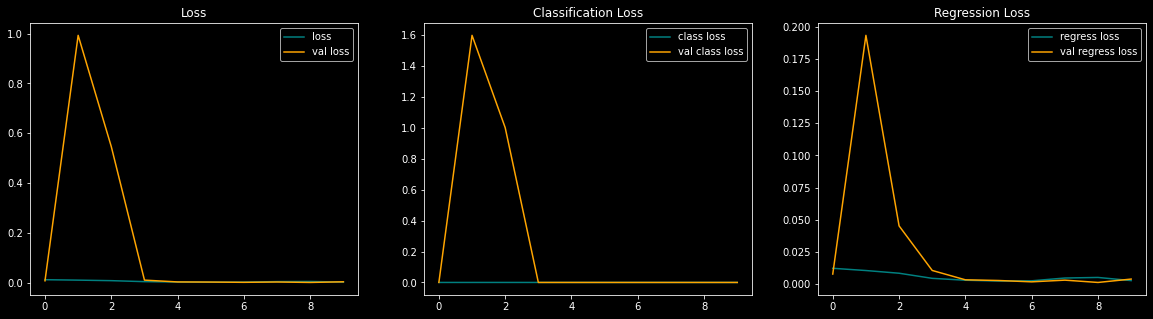

In [86]:
# Performance

fig, ax = plt.subplots(ncols=3, figsize=(20,5))
history = hist.history
ax[0].plot(history['total_loss'], color='teal', label='loss')
ax[0].plot(history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(history['classification_loss'], color='teal', label='class loss')
ax[1].plot(history['val_classification_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [88]:
model_core.save('model_core.h5')

In [22]:
model_core = load_model('model_core.h5')

## Predictions

In [23]:
CONFIDENCE_LEVEL = 0.7

1/1 [==============================] - 1s 759ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


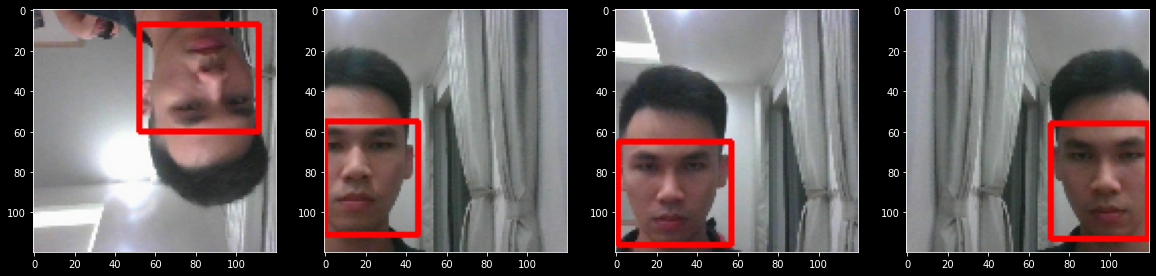

In [87]:
# Make Predictions on Test Set
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
y_hat = model_core.predict(test_sample[0])

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = y_hat[1][idx]
    
    if y_hat[0][idx] > CONFIDENCE_LEVEL:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [24]:
def create_color():
    color = []
    for i in range(3):
        channel = np.random.randint(0, 256)
        color.append(channel)
    return color

In [26]:
# Real Time Detection
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = cv2.flip(frame, 1)
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, IMAGE_SIZE)
    
    y_hat = model_core.predict(np.expand_dims(resized/255,0))
    sample_coords = y_hat[1][0]
    
    if y_hat[0] > CONFIDENCE_LEVEL: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], AUG_IMG_SIZE).astype(int)),
                      tuple(np.multiply(sample_coords[2:], AUG_IMG_SIZE).astype(int)), 
                            create_color(), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], AUG_IMG_SIZE).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], AUG_IMG_SIZE).astype(int),
                                    [80,0])), 
                            create_color(), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], AUG_IMG_SIZE).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('frame', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 74ms/step
